In [98]:
import numpy as np
from gym.utils import seeding
from gym import spaces
import gym

class ClctFourRooms(gym.Env):
    def __init__ (self, num_goals=10, num_types=2, object_priors=[1, 1], reward_vec=None, horizon=200, p=0, config=1, layout='3roomsh', seed=1234, cont=False):
        """
        config -> configouration of the state space
            0 - returns tabular index of the state
            1 - returns one hot encoded vector of the state
            2 - returns matrix form of the state
        """
        if(layout == '4rooms'):
            layout = """\
wwwwwwwwwwwww
w     w     w
w     w     w
w           w
w     w     w
w     w     w
ww wwww     w
w     www www
w     w     w
w     w     w
w           w
w     w     w
wwwwwwwwwwwww
"""
        elif(layout == '3rooms'):
            layout = """\
wwwwwwwwwwwww
w   w   w   w
w   w       w
w   w   w   w
w   w   w   w
w   w   w   w
w   w   w   w
w   w   w   w
w   w   w   w
w       w   w
w   w   w   w
w   w   w   w
wwwwwwwwwwwww
"""
        elif(layout == '3roomsh'):
            layout = """\
wwwwwwwwwwwww
w           w
w           w
wwwwwwwww www
w           w
w           w
w           w
w           w
ww wwwwwwwwww
w           w
w           w
w           w
wwwwwwwwwwwww
"""
        elif(layout == 'maze'):
            layout = """\
wwwwwwwwwwwww
w           w
w ww wwwwww w
w w       w w
w w wwwww w w
w w w   w w w
w w   w   www
w w w   w w w
w w wwwww w w
w w       w w
w ww wwwwww w
w           w
wwwwwwwwwwwww
"""
        elif(layout == 'open'):
            layout = """\
wwwwwwwwwwwww
w           w
w           w
w           w
w           w
w           w
w           w
w           w
w           w
w           w
w           w
w           w
wwwwwwwwwwwww
"""
        else:
            raise
            
        assert num_types == len(object_priors)
            
        self.p = p
        self.config = config
        self.num_goals = num_goals
        self.num_types = num_types
        self.horizon = horizon
        # object priors is the vector of priors of types of each object (so we have to normalize it first)
        self.object_priors = np.array(object_priors) / np.sum(object_priors)
        # reward_vec is the reward vector for different type of objects
        if reward_vec is None:
            self.reward_vec = np.ones(shape=(self.num_types,))
        else:
            self.reward_vec = reward_vec
            
        # store the number of updates
        self.update = 0
        
        # if we would like to create another object when one object is collected
        self.cont = False
        
        # fix the random seed for reproducibility
        np.random.seed(seed)
        self.rng = np.random.RandomState(seed)
        
        # occupancy of the layout(1 -> walls, 0 -> elsewhere)
        self.occupancy = np.array([list(map(lambda c: 1 if c=='w' else 0, line)) for line in layout.splitlines()])
        
        # action space of the env
        # 0: UP
        # 1: DOWN
        # 2: LEFT
        # 3: RIGHT
        self.a_space = np.array([0, 1, 2, 3])
        self.obs_space = np.zeros(np.sum(self.occupancy == 0))
        
        # observation space (Not used)
        # Setting the observation space based on the config
        # The observation space is for the network to know what shape of input it should expect
        if(config <= 1):
            self.observation_space = spaces.Box(low=np.zeros(np.sum(self.occupancy == 0)), high=np.ones(np.sum(self.occupancy == 0)), dtype=np.uint8)
        elif(config == 2):
            self.observation_space = spaces.Box(low=np.zeros([4, 169]), high=np.ones([4, 169]), dtype=np.uint8)
        
        # action space
        self.action_space = spaces.Discrete(4)
        
        # direction of actions
        self.directions = [np.array((-1,0)), np.array((1,0)), np.array((0,-1)), np.array((0,1))]
        
        # a dictionary that can convert state index (scalar) to state cell location (2-dimension vector)
        self.tostate = {}
        statenum = 0
        for i in range(13):
            for j in range(13):
                # first entry is the y index (vertival)
                # second entry is the x index (horizontal)
                if self.occupancy[i,j] == 0:
                    self.tostate[(i,j)] = statenum
                    statenum += 1
        self.tocell = {v:k for k, v in self.tostate.items()}
        
        # get a list of all available states
        self.area = list(range(self.obs_space.shape[0]))
        
        self.channels_all = len(self.reward_vec) + 2
        
        # now we put goals to the env
        # self.reset()
        
    # generate a random location in the environment
    def random_pos(self):
        # choose an random location based on the area
        return np.random.choice(self.area)
        
    def observation(self):
        if self.config == 1:
            # return one hot encoded map
            temp = np.zeros(len(self.obs_space))
            temp[self.agent_pos] = 1
            return temp
        if self.config == 2:
            area = np.zeros([self.channels_all, 13, 13], dtype=np.float32)
            # first channel is the wall
            area[0, :, :] = self.occupancy
            
            # second channel is the agent
            agent_cell = self.tocell[self.agent_pos]
            area[1, agent_cell[0], agent_cell[1]] = 1
            
            # the following channels are objects
            for pos, obj in self.objects.items():
                x, y = self.tocell[pos]
                area[2:, x, y] = obj
                
            return area
        
    def render(self):
        area = np.array(self.occupancy) * (-1)
        agent_cell = self.tocell[self.agent_pos]
        area[agent_cell[0], agent_cell[1]] = 10
        for pos, obj in self.objects.items():
            x, y = self.tocell[pos]
            area[x, y] = obj[0] * 5 + 1
            
        return area
        
        
    def reset(self):
        # clear the update count
        self.update = 0
        
        # first put objects to the env (each object is at different places)
        self.objects = {}
        for _ in range(self.num_goals):
            while True:
                new_pos = self.random_pos()
                if new_pos not in self.objects:
                    self.objects[new_pos] = np.random.multinomial(1, self.object_priors)
                    break
                    
        # Then we put the agent to the env
        self.agent_pos = self.random_pos()
        # if the agent is put onto an object, re-locate the agent
        while self.agent_pos in self.objects:
            self.agent_pos = self.random_pos()
        
        # now we have already put the agent and the objects into the env properly
        
        return self.observation()
    
    # step function for scavenger env
    def step_scavenger(self, action):
        # increase the update count
        self.update += 1
        
        # determine the next position
        agent_cell = self.tocell[self.agent_pos]
        next_cell = tuple(agent_cell + self.directions[action])
        
        # check if the next position is legal (not in the wall), if it is legal, make the move
        # otherwise, stay still
        if not self.occupancy[next_cell]:
            self.agent_pos = self.tostate[next_cell]
        
        # then we see if any object is collected
        # if no object is consumed, we will get an zero vector
        consumed = self.objects.pop(self.agent_pos, np.zeros(shape=(len(self.reward_vec,))))
           
        # calculate the reward
        reward = np.dot(self.reward_vec, consumed)
        
        # if this game is continuous (never end until the horizon is reached), then we would need to create another object if one object is collected
        if self.cont and reward != 0:
            while True:
                new_pos = self.random_pos()
                if new_pos not in self.objects and new_pos != self.agent_pos:
                    self.objects[new_pos] = np.random.multinomial(1, self.object_priors)
                    break
        
        # make sure that the objects is removed
        assert self.agent_pos not in self.objects
                                    
        # then we check if this episode is over
        done = False
        if (self.update >= self.horizon):
            done = True
        
                                    
        # return the observations and the reward
        return self.observation(), reward, done, {}
    
    
    # step function for simple env
    def step_simple(self, action):
        # increase the update count
        self.update += 1
        
        # determine the next position
        agent_cell = self.tocell[self.agent_pos]
        next_cell = tuple(agent_cell + self.directions[action])
        
        # check if the next position is legal (not in the wall), if it is legal, make the move
        # otherwise, stay still
        if not self.occupancy[next_cell]:
            self.agent_pos = self.tostate[next_cell]
            
        # then we see if any object is collected
        # if no object is consumed, we will get an zero vector
        consumed = self.objects.pop(self.agent_pos, np.zeros(shape=(len(self.reward_vec,))))
           
        # calculate the reward
        reward = np.dot(self.reward_vec, consumed)
        
        done = False
        if reward != 0:
            done = True
            reward = 0
        else:
            reward = -1
            
        return self.observation(), reward, done, {}
    
    def step(self, action):
        return step_simple(self, action)
            

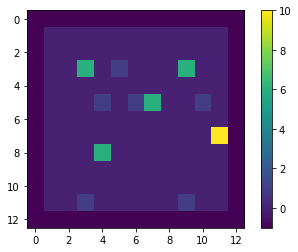

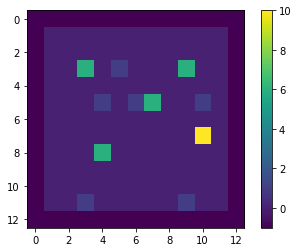

In [97]:
env = ClctFourRooms(config=2, layout='open');
env.reset()

plt.figure()
plt.imshow(env.render())
plt.colorbar()

env.step(2)
plt.figure()
plt.imshow(env.render())
plt.colorbar()
# show_pos(env)

In [62]:
env = ClctFourRooms(config=2);
env.reset()
# print(env.observation_space.shape)

# int(np.prod(env.observation_space.shape))
# print(env.agent_pos)
env.agent_pos = 0
print(env.tocell[env.agent_pos])
print(env.tocell)
print(env.observation()[3])
print(env.agent_pos)

(1, 1)
{0: (1, 1), 1: (1, 2), 2: (1, 3), 3: (1, 4), 4: (1, 5), 5: (1, 6), 6: (1, 7), 7: (1, 8), 8: (1, 9), 9: (1, 10), 10: (1, 11), 11: (2, 1), 12: (2, 2), 13: (2, 3), 14: (2, 4), 15: (2, 5), 16: (2, 6), 17: (2, 7), 18: (2, 8), 19: (2, 9), 20: (2, 10), 21: (2, 11), 22: (3, 9), 23: (4, 1), 24: (4, 2), 25: (4, 3), 26: (4, 4), 27: (4, 5), 28: (4, 6), 29: (4, 7), 30: (4, 8), 31: (4, 9), 32: (4, 10), 33: (4, 11), 34: (5, 1), 35: (5, 2), 36: (5, 3), 37: (5, 4), 38: (5, 5), 39: (5, 6), 40: (5, 7), 41: (5, 8), 42: (5, 9), 43: (5, 10), 44: (5, 11), 45: (6, 1), 46: (6, 2), 47: (6, 3), 48: (6, 4), 49: (6, 5), 50: (6, 6), 51: (6, 7), 52: (6, 8), 53: (6, 9), 54: (6, 10), 55: (6, 11), 56: (7, 1), 57: (7, 2), 58: (7, 3), 59: (7, 4), 60: (7, 5), 61: (7, 6), 62: (7, 7), 63: (7, 8), 64: (7, 9), 65: (7, 10), 66: (7, 11), 67: (8, 2), 68: (9, 1), 69: (9, 2), 70: (9, 3), 71: (9, 4), 72: (9, 5), 73: (9, 6), 74: (9, 7), 75: (9, 8), 76: (9, 9), 77: (9, 10), 78: (9, 11), 79: (10, 1), 80: (10, 2), 81: (10, 3), 8

In [8]:
arena_size = 121

num_channels_all = 4

arena_shape = [arena_size] * 2 + [num_channels_all]

print(arena_shape)

[121, 121, 4]


In [19]:
class SRNet(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body, hidden_units=(), gate=F.relu, config=1):
        """
        config -> type of learning on top of state abstraction
            0 - typical SR with weights sharing
            1 - learning SR without weights sharing
        """
#         print(type(self))
#         print(SRNet)
        super(SRNet, self).__init__()
        # super(SRNet, self).all(*args, **kwargs)
        self.body = body
        self.output_dim = output_dim# TODO: check if this is the right way to do it
        dims = (body.feature_dim,) + hidden_units + (body.feature_dim * output_dim,)
        self.layers = nn.ModuleList(
            [layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        
        self.gate = gate
        self.feature_dim = body.feature_dim * output_dim
        if(config == 0):
            self.psi2q = Psi2QNet(output_dim, body.feature_dim)
        if(config == 1):
            self.psi2q = Psi2QNetFC(output_dim, body.feature_dim)

        self.to(Config.DEVICE)



    def forward(self, x):
        print(f'init shape {x.shape}')
        phi = self.body(tensor(x)) # shape: b x state_dim
        print(f'shape after body process {phi.shape}')
        psi = phi
        for layer in self.layers[:-1]:
            psi = self.gate(layer(psi))
            print(f'shape after linear layer process {psi.shape}')
        psi = self.layers[-1](psi)
        print(f'shape after linear layer process {psi.shape}')
        
        print(f'debug : {psi.shape}, {psi.size(0)}, {self.output_dim}, {self.body.feature_dim}')
        
        psi = psi.view(psi.size(0), self.output_dim, self.body.feature_dim) # shape: b x action_dim x state_dim
        print(f'shape before psi2q {phi.shape}')
        out = self.psi2q(psi)
        print(f'shape after psi2q psi2q {phi.shape}')

        return phi, psi, out

In [21]:
state = np.zeros([13, 13, 4])

2048 (2000,) 169 4


RuntimeError: shape '[101, 1, 13, 13]' is invalid for input of size 101